In [1]:
import numpy as np
import math
import  re
import time
from tqdm import tqdm_notebook 
from collections import defaultdict
from sklearn.model_selection import train_test_split
from functools import reduce

Чтение полученного разбиения на кластеры и добавление в словарь

In [23]:
#f = open('fout_exemplars.txt','r')
f = open('C:\\Users\\Nuts\\Documents\\Visual Studio 2015\\Projects\\AffinityPropagation\\AffinityPropagation\\fout_exemplars_06.txt','r')
#соответсвие между юзерами и кластремами, ключ: user_id
id_cluster = defaultdict()

#ключ : n_cluster
cluster_id = defaultdict(list)

for line in tqdm_notebook(f):
    splited_line = re.split(r'\t',line)
    _id = int(splited_line[0])
    n_cluster = int(splited_line[1])
    id_cluster[_id] = n_cluster
    cluster_id[n_cluster].append(_id)


A Jupyter Widget

In [39]:
len(cluster_id) ## число полученых кластеров

47541

Чтение локаций и создание словаря, хранящего чекины каждого юзера

In [25]:
f = open("Gowalla_totalCheckins.txt", "r")

user_loc = defaultdict(list)

for line in tqdm_notebook(f):
    splited_line = re.split(r'\t',line)
    user_id = int(splited_line[0])
    location_id = int(splited_line[4])
    #добавление в словарь
    user_loc[user_id].append(location_id)

    
    

A Jupyter Widget

Разделение юзеров на тренировочных и тестовых(кому будут строиться рекомендации)

In [26]:
user_ids = user_loc.keys() #только те юзеры, которые имеют локации
train_ids,test_ids = train_test_split(list(user_ids), test_size = 0.010)


len(user_ids), len(test_ids) # юзеры, имеющие локации (все / тестовые)

(107092, 1071)

Создание словаря, хранящего чекины всех юзеров (из train), входящих в данный кластер.

key = номер кластера

In [27]:

cluster_loc = defaultdict(list)

for i in train_ids:
    cluster = id_cluster[i]
    locations = user_loc[i]
    for location in locations:
        cluster_loc[cluster].append(location)
len(cluster_loc) #число кластеров,попавших в train

35122

Подсчет качества рекомендаций

In [28]:
n = 10 #количество учитываемых топ-локаций

In [29]:
_sum = 0

for _id in tqdm_notebook(test_ids):
    start = time.time()
   
    cluster = id_cluster[_id]
    #полный список предсказанных локаций (несортированных по частоте встречаемости)
    predict_loc = cluster_loc[cluster]
    #print(_id, cluster, len(predict_loc))

    
    #сортировка по частоте встречаемости
    predict_loc = sorted(predict_loc,key=predict_loc.count,reverse=True)
    #print("after sort",_id, cluster, len(predict_loc))

    
    #оставить единственный экземпляр, сохраняя порядок сортировки
    predict_loc = reduce(lambda l,x:l+[x] if x not in l else l, predict_loc,[])
   
    
    #дополнить "ошибками" если меньше 10 локаций в кластере
    while len(predict_loc) < n:
        predict_loc.append(-1)   
    
    #if len(predict_loc)>20000:
        #print("time: ", time.time() - start)
        
    # изменить значение в словаре, оставив только 10 популярных локаций     
    cluster_loc[cluster] = predict_loc[:n] 
     
    #истинные локации юзера
    current_loc = user_loc[_id]
    
    #прибавление числа пересечений 10 предсказанных с реальными локациями юзера
    _sum+= len(set(predict_loc[:n])&set(current_loc))
    #print("sum = ", _sum)
_sum    

A Jupyter Widget

2449

In [30]:

#максимальное число пересечений для всех тестовых юзеров
test_sum = n * len(test_ids) 

#отношение полученной суммы к максимально возможной
_sum / test_sum


0.22866479925303454

In [32]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [33]:
#сортировка по числу юзеров, входящих в каждый кластер
sorted_by_value = sorted(cluster_id.items(), key=lambda kv: len(kv[1]), reverse=True)

Самые большие кластеры

In [34]:
for key, users in sorted_by_value[:20]:
    print("#",key, ':', len(users))

# 220 : 4709
# 440 : 1561
# 505 : 1533
# 1149 : 1333
# 459 : 724
# 527 : 638
# 207 : 411
# 615 : 410
# 2215 : 404
# 3 : 387
# 4370 : 242
# 2196 : 240
# 604 : 227
# 1431 : 226
# 4336 : 207
# 2169 : 200
# 1614 : 200
# 1450 : 196
# 2186 : 188
# 854 : 181


In [35]:
x1 = [] #для кластеров размером (1..10) юзеров
x10 = []  #[10..100]
x100 = []
x1000 = []

for key in range(len(sorted_by_value)):
    value = len(sorted_by_value[key][1])
    if value >1000:
        x1000.append(value)
    elif value > 100:
        x100.append(value)
    elif value >10 :
        x10.append(value)
    else : x1.append(value)
    
    


In [36]:
def histogram(x, n_bins, color, title):
    plt.title('Размер кластеров %s' %title)
    plt.ylabel('Количество кластеров')
    plt.xlabel('Число пользователей в кластере')
    n, bins, patches = plt.hist(x, n_bins, facecolor=color, alpha=0.5)
    plt.show()


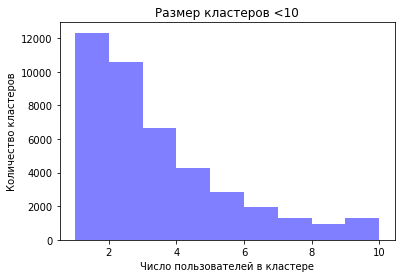

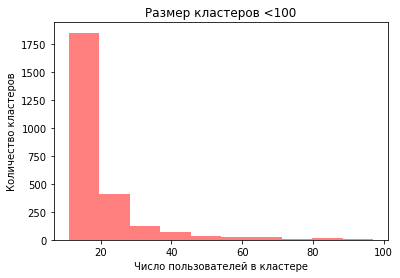

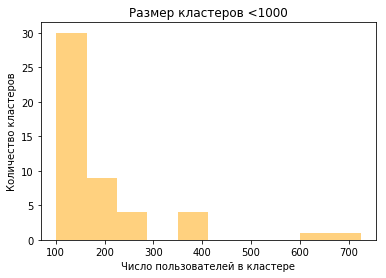

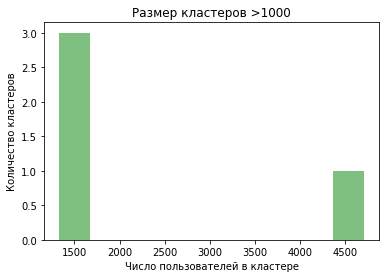

In [40]:
histogram(x1, 9, 'blue', '<10')
histogram(x10, 10, 'red', '<100')
histogram(x100, 10, 'orange', '<1000')
histogram(x1000, 10, 'green', '>1000')